# FPP multi-objective optimization

## Import packages

In [141]:
using Revise
using FUSE
using Plots

## Set baseline `ini` and `act`

In [142]:
ini, act = FUSE.case_parameters(:FPP, version=:v1_demount, init_from=:scalars);

In [143]:
ini.equilibrium.ϵ = 1/3.5
ini.equilibrium.κ = 0.8826 # set less than one so that init uses this as the f_kappa parameter
ini.equilibrium.δ = 0.7
ini.equilibrium.ζ = 0.0
ini.equilibrium.pressure_core = 1.5e6

delete!(ini.build.layers,:hfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_outer)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_outer)

ini.core_profiles.impurity = :Kr
ini.core_profiles.n_shaping = 2.5
ini.core_profiles.T_shaping = 2.5
ini.core_profiles.T_ratio = 0.825
ini.core_profiles.greenwald_fraction = 1.0
ini.core_profiles.ne_ped = missing
ini.core_profiles.greenwald_fraction_ped = 0.7
ini.core_profiles.helium_fraction = 0.04

ini.build.plasma_gap = 0.125
ini.equilibrium.xpoints = :lower
ini.build.divertors = :lower
ini.build.symmetric = false

ini.ec_launchers.power_launched = 25e6

ini.pf_active.n_coils_outside = 8

ini.requirements.flattop_duration = 24*3600.0

ini.requirements

requirements{Float64}
├─ power_electric_net ➡ 2.0e8 [W] Net electric power generated by the fusion power plant
├─ flattop_duration ➡ 86400.0 [s] Duration of the flattop (use Inf for steady-state)
├─ log10_flattop_duration ➡ missing Log10 value of the duration of the flattop (use Inf for steady-state). Preferred over
│  `flattop_duration` for optimization studies.
├─ tritium_breeding_ratio ➡ 1.1 Tritium breeding ratio of the whole plant
├─ cost ➡ missing Total FPP cost
├─ ne_peaking ➡ missing On-axis electron density / volume-averaged electron denstiy
├─ q_pol_omp ➡ missing Poloidal heat flux at the outer midplane
├─ lh_power_threshold_fraction ➡ missing Fraction of the LH power threshold
├─ h98y2 ➡ missing H98y2 ITER elmy H-mode confinement scaling factor
├─ hds03 ➡ missing Petty 2003 H-mode thermal energy confinement scaling factor
├─ βn ➡ missing Normalized total plasma beta (MHD)
├─ coil_j_margin ➡ missing Magnet coil J_crit / J_max
└─ coil_stress_margin ➡ missing Magnet coil yield_

In [144]:
act.ActorEquilibrium.model = :Solovev
act.ActorEquilibrium.symmetrize = false

act.ActorPedestal.update_core_profiles = false
act.ActorPedestal.only_powerlaw = false
act.ActorPedestal.T_ratio_pedestal = 1.0

act.ActorHFSsizing.do_plot = false
act.ActorHFSsizing.verbose = false
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing.aspect_ratio_tolerance = 0.0
act.ActorHFSsizing.error_on_technology = false
act.ActorFluxSwing.operate_oh_at_j_crit = true

act.ActorPFcoilsOpt.do_plot = false
act.ActorPFcoilsOpt.update_equilibrium = false
act.ActorPFcoilsOpt.optimization_scheme = :none

act.ActorPowerNeeds.model = :thermal_power_fraction
act.ActorPowerNeeds.thermal_power_fraction = 0.2

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.4

act.ActorStabilityLimits.raise_on_breach = false
act.ActorStabilityLimits.models = [:beta_troyon_1984, :model_201, :model_401] # include βn check

act.ActorCosting.model = :GASC
act.ActorCosting.production_increase = 10.0
act.ActorCosting.learning_rate = 0.616

act.ActorFixedProfiles.T_shaping = ini.core_profiles.T_shaping
act.ActorFixedProfiles.n_shaping = ini.core_profiles.n_shaping
act.ActorFixedProfiles.T_ratio_pedestal = 1.0
act.ActorFixedProfiles.T_ratio_core = ini.core_profiles.T_ratio

act.ActorCoreTransport.model = :FixedProfiles

act.ActorEquilibriumTransport.do_plot = true
act.ActorEquilibriumTransport.convergence_error = 1e-2
act.ActorEquilibriumTransport

ActorEquilibriumTransport{Float64}
├─ do_plot ➡ true Plot
├─ max_iter ➡ 5 max number of transport-equilibrium iterations
└─ convergence_error ➡ 0.01 Convergence error threshold (relative change in current and pressure profiles)


## Explore sensitivity to changes in `ini` and `act`

In [145]:
ini.equilibrium.B0 = 7.5
ini.equilibrium.ip = 10e6
ini.equilibrium.R0 = 5.0
ini.core_profiles.greenwald_fraction = 1.2
ini.core_profiles.greenwald_fraction_ped = 0.85
ini.equilibrium.pressure_core = 1.0e6

act.ActorHFSsizing.do_plot = true
act.ActorHFSsizing.verbose = true
act.ActorEquilibrium.model = :Solovev
act.ActorHFSsizing.error_on_technology = false

false

## Set ini values and ranges for optimizer

In [146]:
# nominal value and ranges
ini.ec_launchers.power_launched = ini.ec_launchers.power_launched[1] ↔ [1e6, 200e6];
ini.core_profiles.greenwald_fraction = ini.core_profiles.greenwald_fraction ↔ [0.86, 1.3]
ini.core_profiles.greenwald_fraction_ped = ini.core_profiles.greenwald_fraction_ped ↔ [0.1, 0.85]
ini.equilibrium.B0 = ini.equilibrium.B0 ↔ [1.0, 20.0]
ini.equilibrium.ip = ini.equilibrium.ip ↔ [1.0e6, 22e6]
ini.equilibrium.R0 = ini.equilibrium.R0 ↔ [1.0, 15.0]
ini.equilibrium.pressure_core = ini.equilibrium.pressure_core ↔ [0.1e6, 3.0e6];
ini.requirements.ne_peaking = 1.5;
ini.requirements.q_pol_omp = 2.75e9;
ini.requirements.lh_power_threshold_fraction = 1.0;
ini.requirements.hds03 = 1.0;
ini.requirements.coil_j_margin = 1.5;
ini.requirements.coil_stress_margin = 1.0;

## Run optimization workflow function

Jtor0_before = 2.32 MA
P0_before = 984.38 kPa
βn_MHD = 2.18
βn_tot = 1.74
Te_ped = 2.20e+03 eV
rho_ped = 0.9500

Jtor0_after = 1.82 MA
P0_after = 984.38 kPa
βn_MHD = 1.89
βn_tot = 1.89
Te_ped = 3.86e+03 eV
rho_ped = 0.9467


[ Info: Iteration = 1 , convergence error = 0.08977, threshold = 0.01



Jtor0_after = 1.81 MA
P0_after = 984.38 kPa
βn_MHD = 1.90
βn_tot = 1.90
Te_ped = 3.89e+03 eV
rho_ped = 0.9465


[ Info: Iteration = 2 , convergence error = 0.00325, threshold = 0.01


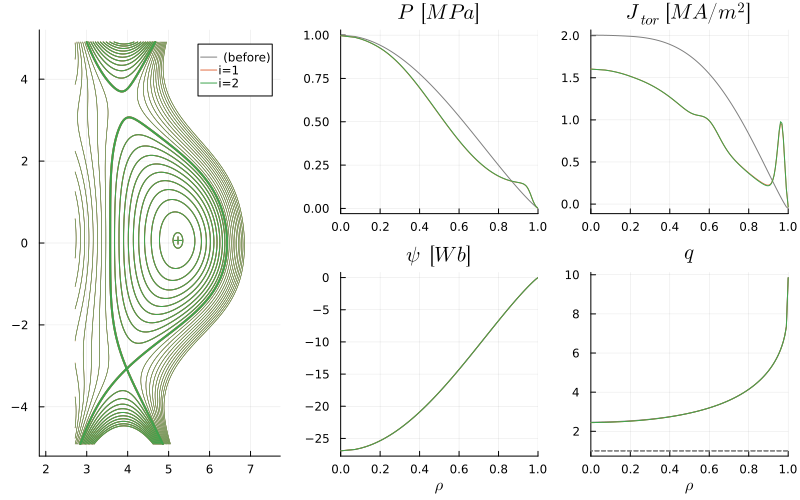

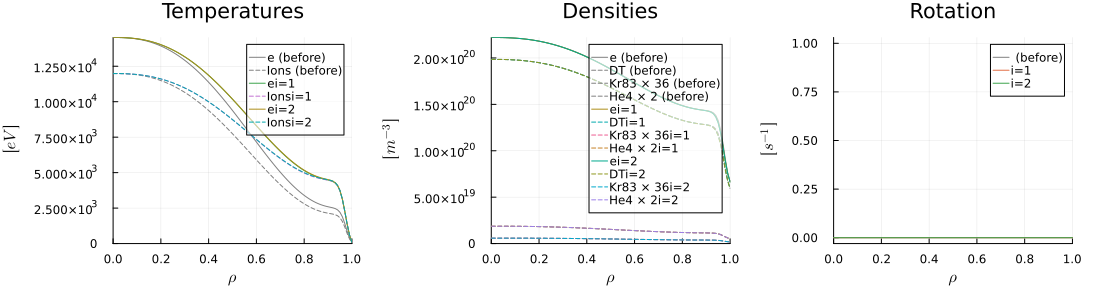

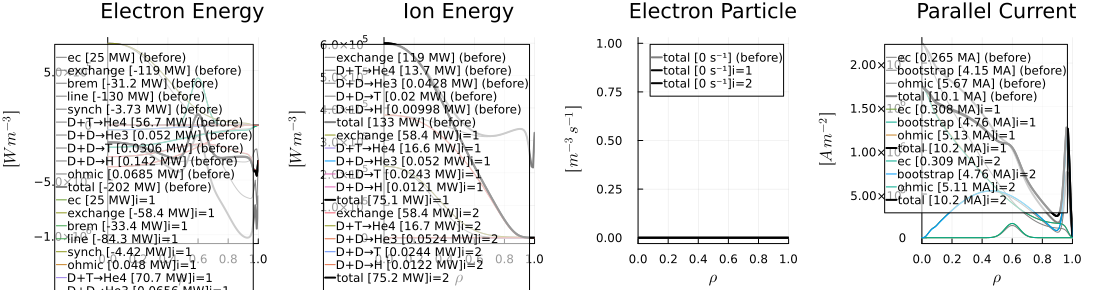

 * Status: success

 * Candidate solution
    Final objective value:     1.114882e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    244
    f(x) calls:    466


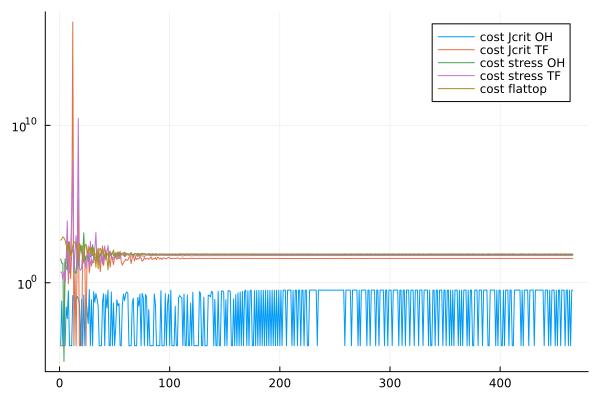

[PL.thickness] = [1.1647129698243401]
[OH.thickness, dd.build.oh.technology.fraction_steel] = [0.5698465798425151, 0.4790869166524815]
[TFhfs.thickness, dd.build.tf.technology.fraction_steel] = [0.1941729854283965, 0.6318018733855023]

target_B0 = 7.500254690040111
(dd.build.tf.max_b_field * TFhfs.end_radius) / R0 = 7.50025469004011

dd.build.oh.flattop_duration = 80682.97450349297
dd.requirements.flattop_duration = 86400.0

dd.build.oh.max_j = 3.873371505341713e7
dd.build.oh.critical_j = 5.790362242248022e7

dd.build.tf.max_j = 8.076381911913255e7
dd.build.tf.critical_j = 9.319489869000947e7

maximum(dd.solid_mechanics.center_stack.stress.vonmises.oh) = 2.368147919773759e9
dd.solid_mechanics.center_stack.properties.yield_strength.oh = 8.0e8

maximum(dd.solid_mechanics.center_stack.stress.vonmises.tf) = 3.956110902543366e9
dd.solid_mechanics.center_stack.properties.yield_strength.tf = 8.0e8

old_R0 / a = 3.1118827408271534
R0 / a = 3.1118827408271534


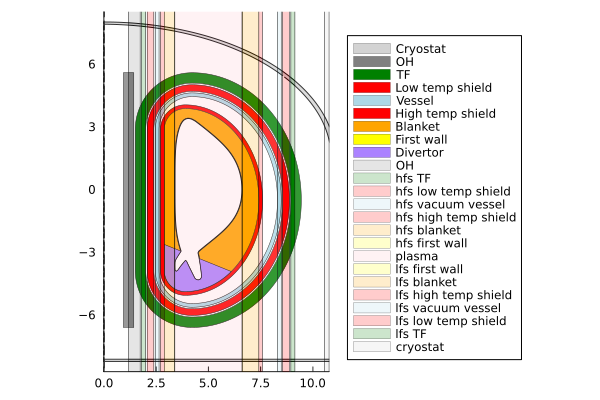

 41.035636 seconds (151.91 M allocations: 8.089 GiB, 2.98% gc time, 2.97% compilation time: 38% of which was recompilation)


In [147]:
function my_workflow(ini::FUSE.ParametersInits, act::FUSE.ParametersActors)
    
    ### modify ini layers

    R0 = ini.equilibrium.R0
    ϵ = ini.equilibrium.ϵ
    a = R0 * ϵ

    RiPlasma = R0 - a

    # HFS layers

    ini.build.layers[:plasma] = 2*a*(1+ini.build.plasma_gap)
    ini.build.layers[:hfs_first_wall] = 0.02
    ini.build.layers[:hfs_blanket] = 0.55*((1/ϵ-1.8)/2.2)^0.5
    ini.build.layers[:hfs_high_temp_shield] = RiPlasma*0.05
    ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.02
    ini.build.layers[:hfs_vacuum_vessel] = RiPlasma * 0.05
    ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
    ini.build.layers[:hfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
    ini.build.layers[:hfs_gap_low_temp_shield_TF] = RiPlasma * 0.02

    rbCenterPost = (R0 - 0.5*ini.build.layers[:plasma] - ini.build.layers[:hfs_first_wall] - ini.build.layers[:hfs_blanket]
        - ini.build.layers[:hfs_high_temp_shield] - ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel]
        - ini.build.layers[:hfs_vacuum_vessel] - ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield]
        - ini.build.layers[:hfs_low_temp_shield] - ini.build.layers[:hfs_gap_low_temp_shield_TF]);

    ini.build.layers[:hfs_TF] = rbCenterPost * 0.25
    ini.build.layers[:OH] = rbCenterPost * 0.25
    ini.build.layers[:gap_TF_OH] = RiPlasma * 0.02
    ini.build.layers[:gap_OH] = rbCenterPost - ini.build.layers[:hfs_TF] - ini.build.layers[:gap_TF_OH] - ini.build.layers[:OH]

    # LFS layers

    ini.build.layers[:lfs_first_wall] = 0.02
    ini.build.layers[:lfs_blanket] = 1.0 - 0.25*((1/ϵ-2.1)/1.9)^0.5
    ini.build.layers[:lfs_high_temp_shield] = RiPlasma * 0.05
    ini.build.layers[:lfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.2
    ini.build.layers[:lfs_vacuum_vessel] = RiPlasma * 0.05
    ini.build.layers[:lfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
    ini.build.layers[:lfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
    ini.build.layers[:lfs_gap_low_temp_shield_TF] = RiPlasma * 0.02
    ini.build.layers[:lfs_TF] = ini.build.layers[:hfs_TF]

    ### run init
    dd = FUSE.init(ini, act)

    ### run main compound actor
    
    # stand-alone EquilibriumTransport to check core convergence
    #FUSE.ActorEquilibriumTransport(dd, act);
    
    # or full WholeFacility to run through entire workflow
    FUSE.ActorWholeFacility(dd, act)
    
    return dd

end

@time dd = my_workflow(ini, act);


## Run digest

GEOMETRY                         EQUILIBRIUM                      TEMPERATURES                     DENSITIES                        
─────────────────────────────    ─────────────────────────────    ─────────────────────────────    ─────────────────────────────    
R0 → 5 [m]                       B0 → 7.5 [T]                     Te0 → 14.5 [keV]                 ne0 → 2.22e+20 [m⁻³]             
a → 1.43 [m]                     ip → 10 [MA]                     Ti0 → 12 [keV]                   ne_ped → 1.33e+20 [m⁻³]          
1/ϵ → 3.5 [m]                    q95 → 5.95                       <Te> → 7.8 [keV]                 <ne> → 1.67e+20 [m⁻³]            
κ → 2.15                         <Bpol> → 0.836 [T]               <Ti> → 6.91 [keV]                ne0/<ne> → 1.33                  
δ → 0.7                          βpol_MHD → 1.33                  Te0/<Te> → 1.86                  fGW → 1.2                        
ζ → -0.111                       βtor_MHD → 0.0177                Ti0

​


24×9 DataFrame
 Row │ group   details     type      ΔR         R_start   R_end     material      area       volume     
     │ String  String      String    Float64    Float64   Float64   String        Float64    Float64    
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                            1.16471     0.0       1.16471                13.3519      48.8554
   2 │ in                  oh        0.569847    1.16471   1.73456  ReBCO          6.53255     59.5007
   3 │ in                            0.0714416   1.73456   1.806                   0.818986     9.10958
   4 │ hfs                 tf        0.194173    1.806     2.00017  ReBCO          5.86437     73.7003
   5 │ hfs                           0.0714416   2.00017   2.07162                 2.11832     66.649
   6 │ hfs     low temp    shield    0.318201    2.07162   2.38982  Steel          8.95331    282.254
   7 │ hfs                           0.0714416   2.38

​


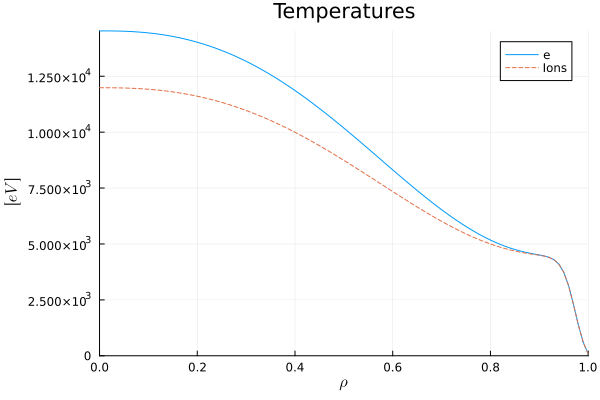

​


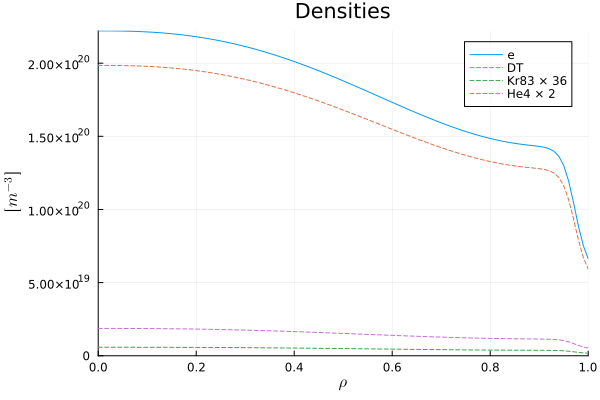

​


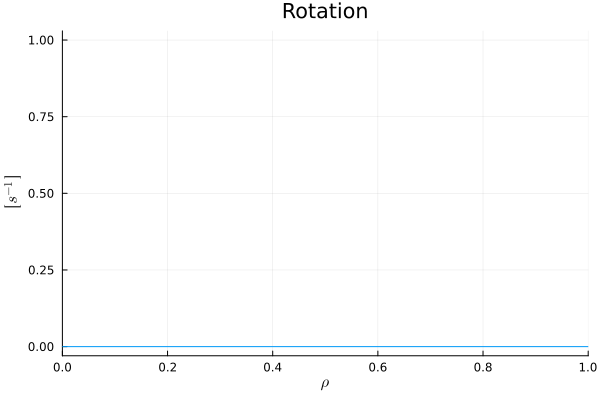

​


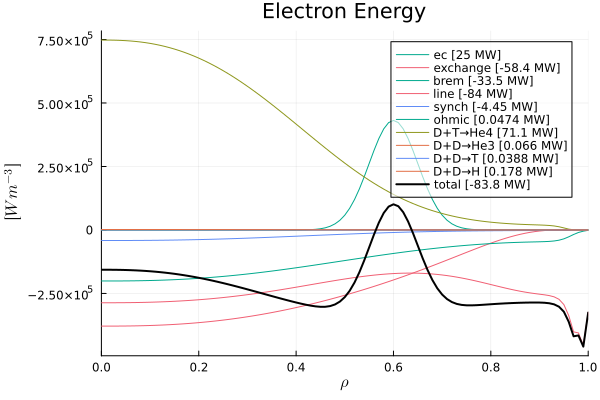

​


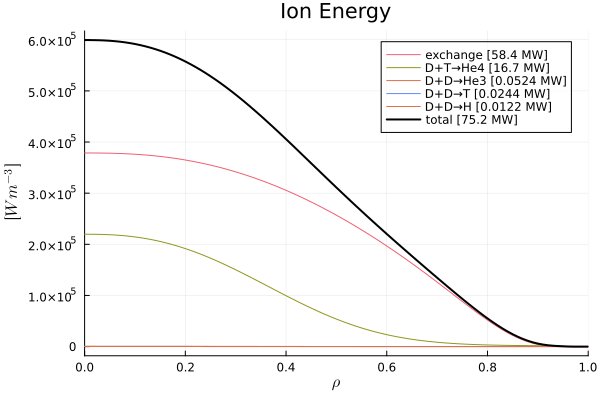

​


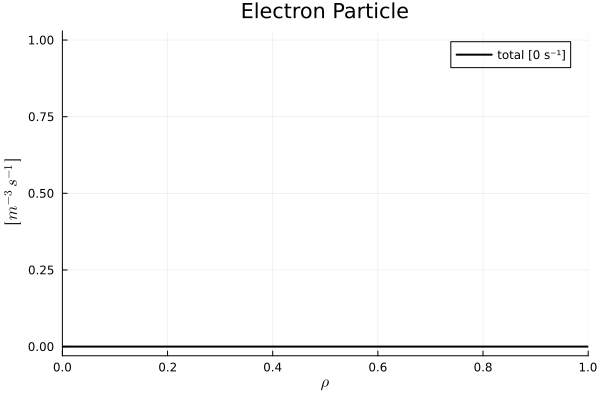

​


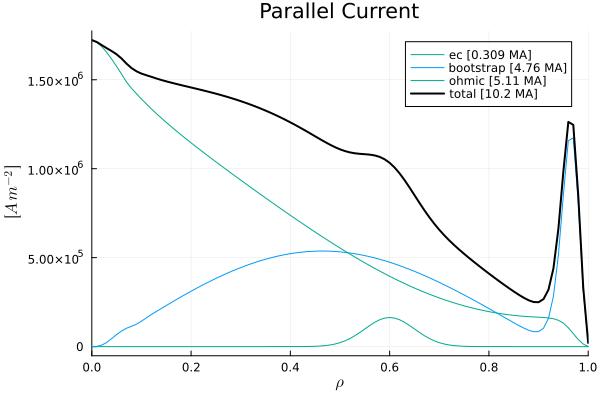

​


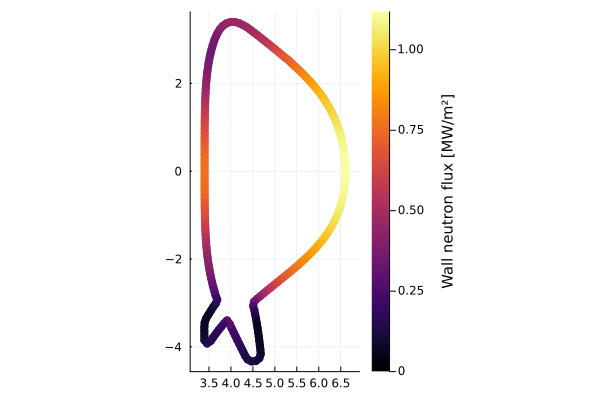

​


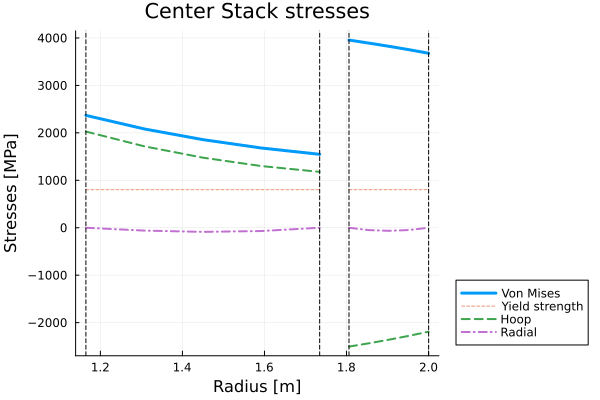

​


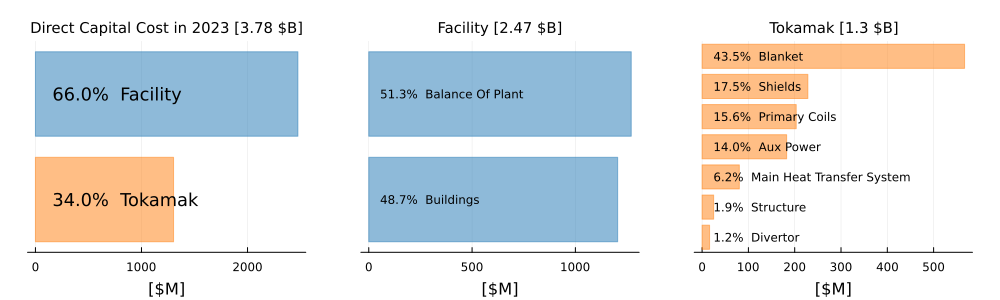

In [148]:
FUSE.digest(dd)

## Check optimization_workflow 

In [149]:
# FUSE comes with a library of objective and constraints functions
OFL = deepcopy(FUSE.ObjectiveFunctionsLibrary)
CFL = deepcopy(FUSE.ConstraintFunctionsLibrary)

objectives_functions = [
    OFL[:min_capital_cost], 
    OFL[:min_βn],
]
constraints_functions = [
    CFL[:min_required_power_electric_net], 
    CFL[:max_ne_peaking], 
    CFL[:max_ωpe_ωce], 
    CFL[:min_lh_power_threshold], 
    CFL[:max_qpol_omp], 
    CFL[:max_hds03], 
    CFL[:max_tf_j],
    CFL[:max_oh_j],
    CFL[:max_tf_stress],
    CFL[:max_oh_stress],
]
println("== OBJECTIVE FUNCTIONS ==")
display(objectives_functions)
println()
println("== CONSTRAINT FUNCTIONS ==")
display(constraints_functions)

== OBJECTIVE FUNCTIONS ==


2-element Vector{FUSE.ObjectiveFunction}:
 min_capital_cost → -Inf [$B]
 min_βn → -Inf []


== CONSTRAINT FUNCTIONS ==


10-element Vector{FUSE.ConstraintFunction}:
 min_required_power_electric_net > 0.0 [%]
 max_ne_peaking < 0.0 [%]
 max_ωpe_ωce < 1.0 [%]
 min_lh_power_threshold > 0.0 [%]
 max_qpol_omp < 0.0 [%]
 max_hds03 < 0.0 [%]
 max_tf_j > 0.0 [%]
 max_oh_j > 0.0 [%]
 max_tf_stress > 0.0 [%]
 max_oh_stress > 0.0 [%]

In [150]:
import SimulationParameters: opt_parameters, float_bounds

# itentify optimization variables in ini
opt_ini = opt_parameters(ini)
println("== Actuators ==")
for optpar in opt_ini
    println(optpar)
end
println()
println("== Objectives ==")
for objf in objectives_functions
    println(objf)
end
println()
println("== Constraints ==")
for cnst in constraints_functions
    println(cnst)
end

# optimization boundaries
bounds = [[float_bounds(optpar)[1] for optpar in opt_ini] [float_bounds(optpar)[2] for optpar in opt_ini]]'


== Actuators ==
ini.equilibrium.B0
- units: T
- description: Vacuum toroidal field at R0 [T]; Positive sign means anti-clockwise when viewing from above. The product R0B0 must be consistent with the b_tor_vacuum_r field of the tf IDS.
- value: 7.5
- base: 4.713171689711136
- default: missing
- opt: SimulationParameters.OptParameterRange{Float64}(7.5, 1.0, 20.0, Missing[])
ini.equilibrium.R0
- units: m
- description: Geometric genter of the plasma. NOTE: This also scales the radial build layers.
- value: 5.0
- base: 4.824432302041749
- default: missing
- opt: SimulationParameters.OptParameterRange{Float64}(5.0, 1.0, 15.0, Missing[])
ini.equilibrium.pressure_core
- units: Pa
- description: On axis pressure
- value: 1.0e6
- base: 1.5587652064765713e6
- default: missing
- opt: SimulationParameters.OptParameterRange{Float64}(1.0e6, 100000.0, 3.0e6, Missing[])
ini.equilibrium.ip
- units: A
- description: Plasma current (toroidal component). Positive sign means anti-clockwise when viewed from

2×7 adjoint(::Matrix{Float64}) with eltype Float64:
  1.0   1.0  100000.0    1.0e6  0.86  0.1   1.0e6
 20.0  15.0       3.0e6  2.2e7  1.3   0.85  2.0e8

In [151]:
dd.build.pf

LoadError: type build has no field pf

In [152]:
dd.solid_mechanics.center_stack.properties.yield_strength.tf

8.0e8